# Introduction  

**!Recommend to view the notebook on Github!**  
Github Link : https://github.com/heartcored98/CH485_AI_Chemistry/blob/master/Practice5_logP_GCN/Assignment5_logP_GCN.ipynb 

In this jupyter notebook, a logP of the molecular will be predicted with the GCN on zinc_smiles dataset.  
**zinc_smiles** dataset consists of molecular smile strings as inputs and the logP values were calculated with RDkit

This notebook has following features  
- Convert smile string into one-hot encoded matrix with **pytorch embedding layer**.  
- Support data spliting with sklearn **test_train_split** process easily.  
- Support atom embedding training with **pytorch embedding layer**. 
- Support **residual GCN block** with different architecture (skip-connection or gated-skip-connection).   
- Support **multi-head attention** architecture.
- Support enable/disable using **batch normalization**.   
- Manage experiment and model _hyperparameters_ at once with **argparse**  
- Logging each experiment setting with corresponding results in json format.  
- _Visualize_ experiment results with minimal changes of codes with **seaborn** and **pandas Dataframe**  

Throughout the notebook, there are **5** experiments with following investigation purpose.  
Note that **regression performance** includes mean_absolute_error(mae) and standard deviation(std)  
1. Influence of the **n_stage** vs **n_layer**
2. Influence of the **Block Type** vs **n_stage**.
3. Influence of the **Trainable Embedding** vs **Start Channel**.  
4. Influence of the **Learning rate** vs **L2 regularzation coefficient**.  
4. Influence of the **Use Attention** vs **n_layer**.  

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import time
from copy import deepcopy
import argparse
import sys
import traceback
import json
from tqdm import tqdm_notebook, tqdm

import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.autograd import Variable
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import FontProperties
from utils import *
from visual_tool import *


parser = argparse.ArgumentParser()

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

# 1. Prepare Dataset

In [4]:
partition = make_partition(80000, 0.1, 0.1, 123)

# 2. Model Architecture

Create char_to_ix Ref: https://github.com/pytorch/tutorials/blob/master/beginner_source/nlp/word_embeddings_tutorial.py  
Pre-defined Embedding Layer Ref: https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76  

# 3. Train, Validate, Evaluate

In [5]:
def train(model, partition, optimizer, criterion, args, **kwargs):
    data_iter = DataLoader(
        partition['train'],
        batch_size=args.batch_size,
        shuffle=args.shuffle,
#         num_workers=4,
        pin_memory=True,
    )
    
    epoch_train_loss = 0
    list_train_loss = list()
    cnt_iter = 0
    for batch_idx, batch in enumerate(data_iter):
        X, A, y = batch
        X, A, y = X.to(args.device).long(), A.to(args.device).float(), y.to(args.device).float()
#         A = to_sparse(A)
        
        model.train()
        optimizer.zero_grad()
        pred_y = model(X, A)
        train_loss = criterion(pred_y, y)
        epoch_train_loss += train_loss.item()
        list_train_loss.append({'epoch':batch_idx/len(data_iter)+kwargs['epoch'], 'train_loss':train_loss.item()})
        train_loss.backward()
        optimizer.step()
        
        cnt_iter += 1
        args.bar.update(len(X))
    return model, list_train_loss

def validate(model, partition, criterion, args):
    data_iter = DataLoader(
        partition['val'],
        batch_size=args.test_batch_size,
        shuffle=args.shuffle
    )
    
    epoch_val_loss = 0
    cnt_iter = 0
    for batch_idx, batch in enumerate(data_iter):
        X, A, y = batch
        X, A, y = X.to(args.device).long(), A.to(args.device).float(), y.to(args.device).float()
    
        model.eval()
        pred_y = model(X, A)
        pred_y.require_grad = False
        val_loss = criterion(pred_y, y)
        epoch_val_loss += val_loss.item()
        cnt_iter += 1

    return epoch_val_loss/cnt_iter

def test(model, partition, args, **kwargs):
    data_iter = DataLoader(
        partition['test'],
        batch_size=args.test_batch_size,
        shuffle=False
    )
    
    list_y, list_pred_y = list(), list()
    for batch_idx, batch in enumerate(data_iter):
        X, A, y = batch
        X, A, y = X.to(args.device).long(), A.to(args.device).float(), y.to(args.device).float()
    
        model.eval()
        pred_y = model(X, A)
        list_y += y.cpu().detach().numpy().tolist()
        list_pred_y += pred_y.cpu().detach().numpy().tolist()
        args.bar.update(len(X))

    mae = mean_absolute_error(list_y, list_pred_y)
    std = np.std(np.array(list_y)-np.array(list_pred_y))
    return mae, std, list_y, list_pred_y

def experiment(partition, args):
    ts = time.time()
    args.vocab_size = 40
    args.max_len = 50
    model = Net(args)
    model.to(args.device)
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(pytorch_total_params)
    criterion = nn.MSELoss()
    
    # Initialize Optimizer
    trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
    if args.optim == 'ADAM':
        optimizer = optim.Adam(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'RMSProp':
        optimizer = optim.RMSprop(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    else:
        assert False, "Undefined Optimizer Type"
        
    # Train, Validate, Evaluate
    list_train_loss = list()
    list_val_loss = list()
    list_mae = list()
    list_std = list()
    
    args.best_mae = 10000
    for epoch in range(args.epoch):
        model, train_losses = train(model, partition, optimizer, criterion, args, **{'epoch':epoch})
        val_loss = validate(model, partition, criterion, args)
        mae, std, true_y, pred_y = test(model, partition, args, **{'epoch':epoch})

        list_train_loss += train_losses
        list_val_loss.append({'epoch':epoch, 'val_loss':val_loss})
        list_mae.append({'epoch':epoch, 'mae':mae})
        list_std.append({'epoch':epoch, 'std':std})
        
        if args.best_mae > mae or epoch==0:
            args.best_epoch = epoch
            args.best_mae = mae
            args.best_std = std
            args.best_true_y = true_y
            args.best_pred_y = pred_y
    
    te = time.time()
    
    # Logging Experiment Results
    args.elapsed = te-ts
    args.train_losses = list_train_loss
    args.val_losses = list_val_loss
    args.maes = list_mae
    args.stds = list_std
    return args

In [6]:
class Attention(nn.Module):
    def __init__(self, input_dim, output_dim, num_attn_head, dropout=0.1):
        super(Attention, self).__init__()   

        self.num_attn_heads = num_attn_head
        self.attn_dim = output_dim // num_attn_head
        self.projection = nn.ModuleList([nn.Linear(input_dim, self.attn_dim) for i in range(self.num_attn_heads)])
        self.coef_matrix = nn.ParameterList([nn.Parameter(torch.FloatTensor(self.attn_dim, self.attn_dim)) for i in range(self.num_attn_heads)])
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.param_initializer()

    def forward(self, X, A):
        list_X_head = list()
        for i in range(self.num_attn_heads):
            X_projected = self.projection[i](X)
            attn_matrix = self.attn_coeff(X_projected, A, self.coef_matrix[i])
            X_head = torch.matmul(attn_matrix, X_projected)
            list_X_head.append(X_head)
            
        X = torch.cat(list_X_head, dim=2)
        X = self.relu(X)
        return X
            
    def attn_coeff(self, X_projected, A, C):
        X = torch.einsum('akj,ij->aki', (X_projected, C))
        attn_matrix = torch.matmul(X, torch.transpose(X_projected, 1, 2)) 
        attn_matrix = torch.mul(A, attn_matrix)
        attn_matrix = self.dropout(self.tanh(attn_matrix))
        return attn_matrix
    
    def param_initializer(self):
        for i in range(self.num_attn_heads):    
            nn.init.xavier_normal_(self.projection[i].weight.data)
            nn.init.xavier_normal_(self.coef_matrix[i].data)
            

In [7]:
class GConv(nn.Module):
    def __init__(self, input_dim, output_dim, attn):
        super(GConv, self).__init__()
        self.attn = attn
        if self.attn is None:
            self.fc = nn.Linear(input_dim, output_dim)
        
    def forward(self, X, A):
        if self.attn is None:
            x = self.fc(X)
            x = torch.matmul(A, x)
        else:
            x = self.attn(X, A)            
        return x, A
    
class BN1d(nn.Module):
    def __init__(self, out_dim, use_bn):
        super(BN1d, self).__init__()
        self.use_bn = use_bn
        self.bn = nn.BatchNorm1d(out_dim)
             
    def forward(self, x):
        if not self.use_bn:
            return  x
        origin_shape = x.shape
        x = x.view(-1, origin_shape[-1])
        x = self.bn(x)
        x = x.view(origin_shape)
        return x
        
class ResBlock(nn.Module):
    def __init__(self, in_dim, out_dim, use_bn, use_attn, dp_rate, sc_type, n_attn_head=None):
        super(ResBlock, self).__init__()   
        self.use_bn = use_bn
        self.sc_type = sc_type
        
        attn = Attention(in_dim, out_dim, n_attn_head) if use_attn else None
        self.gconv = GConv(in_dim, out_dim, attn)
        
        self.bn1 = BN1d(out_dim, use_bn)
        self.dropout = nn.Dropout2d(p=dp_rate)
        self.relu = nn.ReLU()
        
        if not self.sc_type in ['no', 'gsc', 'sc']:
            raise Exception

        if self.sc_type != 'no':
            self.bn2 = BN1d(out_dim, use_bn)
            self.shortcut = nn.Sequential()
            if in_dim != out_dim:
                self.shortcut.add_module('shortcut', nn.Linear(in_dim, out_dim, bias=False))
                
        if self.sc_type == 'gsc':
            self.g_fc1 = nn.Linear(out_dim, out_dim, bias=True)
            self.g_fc2 = nn.Linear(out_dim, out_dim, bias=True)
            self.sigmoid = nn.Sigmoid()

    def forward(self, _x, A):
        x, A = self.gconv(_x, A)

        if self.sc_type == 'no': #no skip-connection
            x = self.relu(self.bn1(x))
            return self.dropout(x), A
        
        elif self.sc_type == 'sc': # basic skip-connection
            x = self.relu(self.bn1(x))
            x = x + self.shortcut(_x)          
            return self.dropout(self.relu(self.bn2(x))), A
        
        elif self.sc_type == 'gsc': # gated skip-connection
            x = self.relu(self.bn1(x)) 
            x1 = self.g_fc1(self.shortcut(_x))
            x2 = self.g_fc2(x)
            gate_coef = self.sigmoid(x1+x2)
            x = torch.mul(x1, gate_coef) + torch.mul(x2, 1.0-gate_coef)
            return self.dropout(self.relu(self.bn2(x))), A
             
            

class Net(nn.Module):
    def __init__(self, args):
        super(Net, self).__init__()   
        
        # Create Atom Element embedding layer
        self.embedding = self.create_emb_layer(args.vocab_size, args.emb_train)
        
        # Create Residual Convolution layer
        list_gconvs = nn.ModuleList()
        
        hidden_dim = args.hidden_dim1
        for i in range(args.n_stage):
            if i==0:
                list_gconvs.append(ResBlock(58, hidden_dim, args.use_bn, False, args.dp_rate, args.sc_type))
            else:
                list_gconvs.append(ResBlock(hidden_dim, hidden_dim*2, args.use_bn, args.use_attn, args.dp_rate, args.sc_type, args.n_attn_head))
                hidden_dim *= 2
            for j in range(args.n_layer-1):
                list_gconvs.append(ResBlock(hidden_dim, hidden_dim, args.use_bn, args.use_attn, args.dp_rate, args.sc_type, args.n_attn_head))

        self.gconvs = list_gconvs
        for module in self.gconvs:
            module.to(args.device)
        
        # Create MLP layers for regression
        self.fc_readout = nn.Linear(hidden_dim, args.hidden_dim2)
        self.fc1 = nn.Linear(args.hidden_dim2, args.hidden_dim2)
        self.fc2 = nn.Linear(args.hidden_dim2, args.hidden_dim2//2)
        self.fc3 = nn.Linear(args.hidden_dim2//2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    

    def forward(self, x, A):
        A = A.float()
        x = self._embed(x)          # embedding layer
        x, _ = self._encode(x, A)   # encoding through gcn layer
        x = self.sigmoid(torch.sum(self.fc_readout(x), dim=1))     # readout layer 
        x = self.relu(self.fc1(x))                # regressor MLP
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return torch.squeeze(x)
          
    def _embed(self, x):
        embed_x = self.embedding(x[:,:,0])
        x = torch.cat((embed_x, x[:,:,1:].float()), 2)
        return x 
    
    def _encode(self, x, A):
        for i, module in enumerate(self.gconvs):
            x, A = module(x, A)
        return x, A

    def create_emb_layer(self, vocab_size, emb_train):
        emb_layer = nn.Embedding(vocab_size, vocab_size)
        weight_matrix = torch.zeros((vocab_size, vocab_size))
        for i in range(vocab_size):
            weight_matrix[i][i] = 1
        emb_layer.load_state_dict({'weight': weight_matrix})

        if not emb_train:
            emb_layer.weight.requires_grad = False
        return emb_layer

In [8]:
class Attention_old(nn.Module):
    def __init__(self, input_dim, attn_dim):
        super(Attention, self).__init__()
        self.input_dim = input_dim
        self.attn_dim = 50 #attn_dim
        self.weight_q = nn.Linear(input_dim, attn_dim, bias=False)
        self.weight_k = nn.Linear(input_dim, attn_dim, bias=False)

    def forward(self, X, A):
        # Projecting Query and Key into attn_dim dimension
        query_X = self.weight_q(X)
        key_X = self.weight_k(X)
        A = A.clone()
        A[(A <= 0.0).detach()] = -1e9

        
        # Scaled Dot Attention
        scaled_dot_matrix = torch.bmm(query_X, key_X.transpose(1, 2)) / self.attn_dim**0.5
        
        # Masked matrix with Adjcency matrix 
        masked_scaled_dot_matrix = torch.mul(A, scaled_dot_matrix)
#         print(masked_scaled_dot_matrix.shape)
#         normed_masked_scaled_dot_matrix = F.normalize(masked_scaled_dot_matrix, p=1, dim=2)
#         masked_scaled_dot_matrix.masked_fill_(mask, float('-inf'))
#         masked_scaled_dot_matrix[ ()]
#         print(torch.max(masked_scaled_dot_matrix))
#         print(torch.min(masked_scaled_dot_matrix))

        attention_score = F.softmax(masked_scaled_dot_matrix, dim=2)
        """
        for i in range(5):
            print("============")
            print("A")
            print(A[0][i])
            print("A mask")
#             print(mask)
            print("scaled")
            print(scaled_dot_matrix[0][i])
            print("masked")
            print(masked_scaled_dot_matrix[0][i])
            print("attention_score")
            print(attention_score[0][i])
        
        
        raise RuntimeError
        """
        scored_X = torch.matmul(attention_score, X)
#         scored_X = torch.matmul(normed_masked_scaled_dot_matrix, X)

        return scored_X
    
    def new_parameter(self, *size):
        out = Parameter(torch.FloatTensor(*size))
        torch.nn.init.xavier_normal(out)
        return out

# Experiment.1  lr vs l2_coef

In [9]:
writer = Writer(prior_keyword=['n_layer', 'n_stage', 'sc_type', 'use_bn', 'dp_rate', 'emb_train', 'epoch', 'l2_coef', 'lr'])

In [13]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

exp_name = 'exp5_use_attn_n_layer'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = None
args.n_stage = None
args.hidden_dim1 = 64
args.hidden_dim2 = 256
args.n_attn_head = 4
args.sc_type = 'no'
args.use_attn = False #True
args.lr = 0.001
args.l2_coef = 0.001
args.optim = 'ADAM'
args.epoch = 20
args.batch_size= 512
args.test_batch_size= 512
args.emb_train = True
args.use_bn = True
args.dp_rate = 0.0
args.max_len = 50
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'n_stage', 'sc_type', 'use_bn', 'use_attn', 'dp_rate', 'emb_train', 'epoch', 'l2_coef', 'lr'])


# Define Hyperparameter Search Space
list_var1 = [1,2,3,4] #, False]#, 2, 3, 4]#, 4, 8]#[0.01, 0.001, 0.0001, 0.00001]
list_var2 = [1, 2, 3]#,2,3] #[10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]

# Initialize num iteration, num experiment, progress bar
n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_var1)*len(list_var2)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))

writer.clear(exp_name)
for var2 in list_var2:
    for var1 in list_var1:
        ts = time.time()
        # Update hyperparameter
        args.n_layer = var1
        args.n_stage = var2
        
        args.bar = bar
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()

        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} took {:3.1f}sec'.format(cnt_exp, result.best_mae, result.best_std, result.epoch, te-ts))

120961
[Exp  1] got mae: 0.151, std: 0.214 at epoch 20 took 63.6sec
125249
[Exp  2] got mae: 0.092, std: 0.145 at epoch 20 took 74.8sec
129537
[Exp  3] got mae: 0.088, std: 0.143 at epoch 20 took 88.8sec
133825
[Exp  4] got mae: 0.113, std: 0.168 at epoch 20 took 106.0sec
145921
[Exp  5] got mae: 0.100, std: 0.157 at epoch 20 took 81.8sec
166977
[Exp  6] got mae: 0.095, std: 0.130 at epoch 20 took 110.6sec
188033
[Exp  7] got mae: 0.086, std: 0.132 at epoch 20 took 142.6sec
209089
[Exp  8] got mae: 0.103, std: 0.143 at epoch 20 took 173.2sec
212225
[Exp  9] got mae: 0.089, std: 0.143 at epoch 20 took 97.2sec
299585
[Exp 10] got mae: 0.090, std: 0.126 at epoch 20 took 150.3sec
386945
[Exp 11] got mae: 0.096, std: 0.137 at epoch 20 took 200.7sec
474305
[Exp 12] got mae: 0.109, std: 0.151 at epoch 20 took 256.1sec


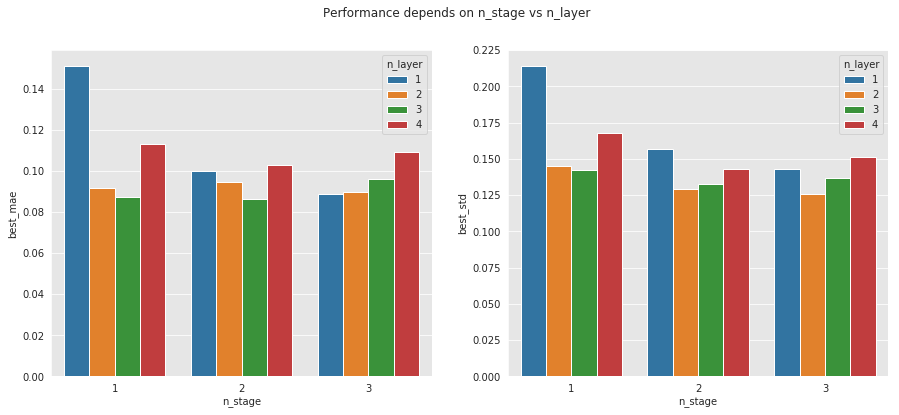

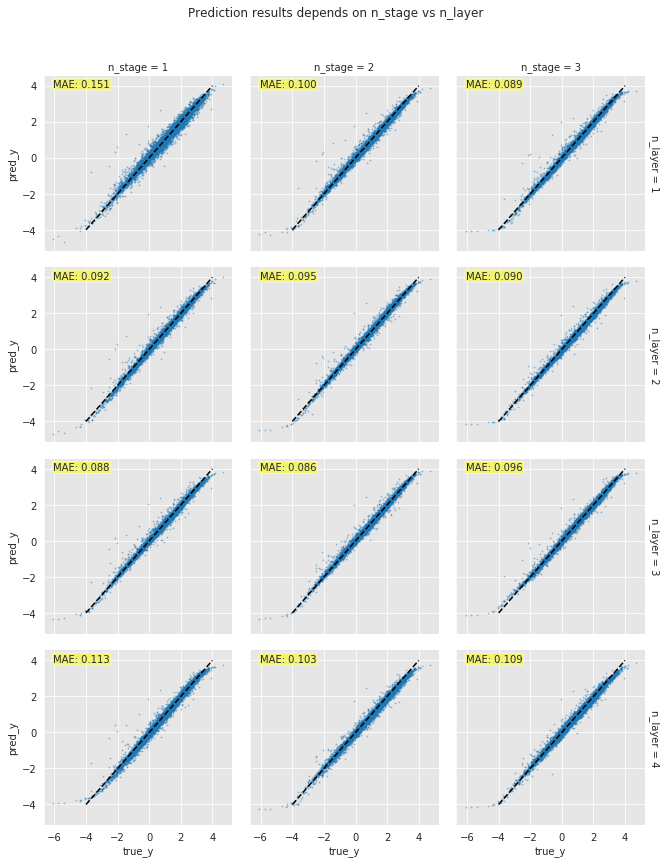

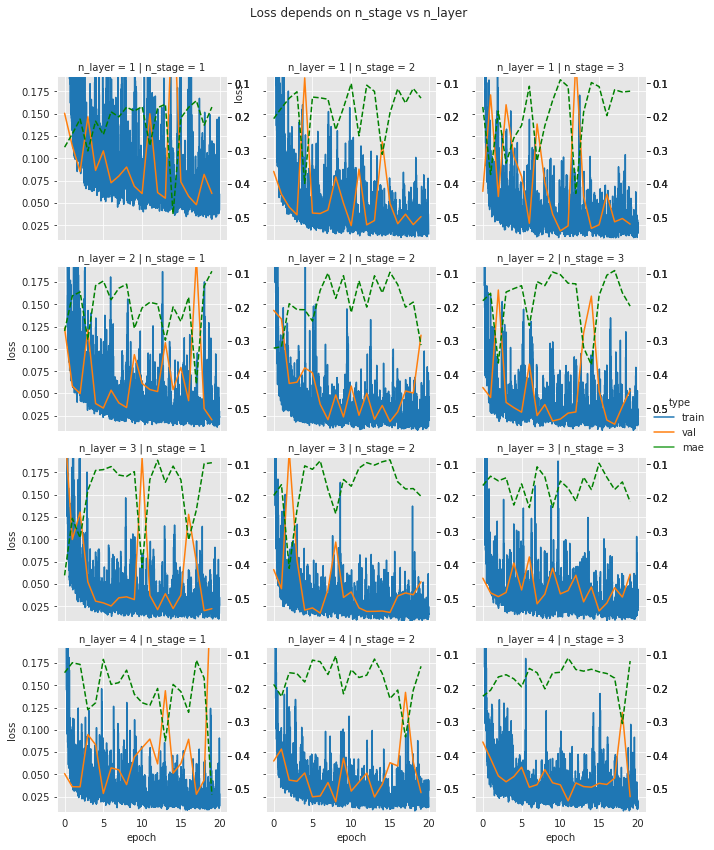

In [20]:
results = writer.read(exp_name='exp5_use_attn_n_layer')

variable2 = 'n_layer'
variable1 = 'n_stage'


plot_performance(results, variable1, variable2,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp1_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 'best_mae',
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Prediction {} vs {}'.format(variable1, variable2), top=0.9)

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Loss {} vs {}'.format(variable1, variable2), top=0.9)

plt.show()


# Experiment.1 n_stage vs n_layer  

In this experiment, regression performance was measured by 'mae' metric among the variation of the number of the residual block(n_stage) and the number of the layer per block(n_layer).  

**Variable Domain**  
- n_stage = [1, 2, 3, 4]  
- n_layer = [1, 2, 3, 4]

# Results and Discussion

1. The first figure shows the mae and std variation depends on the number of residual block and number of convolution layer in the residual block. Also, it notify the experiment settings.  
2. The second figure shows the distribution between ground truth y and predicted y with y=x line(dashed).  
3. The last figure shows the train loss, validation loss(left y-axis) and mae score (right y-axis).  

**Notable Results**  
- As the number of the residual block increased, overall performance was increased.  
- As the number of the layer in a residual block increased, overall performance was decreased.  
- Therefore, 4 block with 1 layer per block achieved highest performance. 

**Discussion**  
- I expected that 4 block with 4 layer per block would outperform other models, however it was not. This results should be reconsidered since the loss chart of 4 block with 4 layer per block shows that the validation loss is still lower than the train loss. Therefore, longer training should be conducted. 
- As expected, the models with less residual block shows poor prediction performance. 

# Experiment.2 Block Type vs N_Stage

In [24]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

exp_name = 'exp2_skipconnection_n_stage'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 1
args.n_stage = None
args.hidden_dim1 = 64
args.hidden_dim2 = 256
args.n_attn_head = None
args.sc_type = None
args.use_attn = False #True
args.lr = 0.001
args.l2_coef = 0.001
args.optim = 'ADAM'
args.epoch = 50
args.batch_size= 512
args.test_batch_size= 512
args.emb_train = True
args.use_bn = True
args.dp_rate = 0.0
args.max_len = 50
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'n_stage', 'sc_type', 'use_bn', 'use_attn', 'dp_rate', 'emb_train', 'epoch', 'l2_coef', 'lr'])



# Define Hyperparameter Search Space
list_var1 = [2, 3, 4]#, 4, 8]#[0.01, 0.001, 0.0001, 0.00001]
list_var2 = ['no', 'sc', 'gsc'] #[10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]

# Initialize num iteration, num experiment, progress bar
n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_var1)*len(list_var2)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))

writer.clear(exp_name)
for var1 in list_var1:
    for var2 in list_var2:
        ts = time.time()
        # Update hyperparameter
#         args.lr = var1
        args.sc_type = var2
        args.n_stage = var1
        args.bar = bar
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()

        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} took {:3.1f}sec'.format(cnt_exp, result.best_mae, result.best_std, result.epoch, te-ts))

145921
[Exp  1] got mae: 0.095, std: 0.147 at epoch 20 took 79.0sec
158209
[Exp  2] got mae: 0.069, std: 0.118 at epoch 20 took 107.2sec
199553
[Exp  3] got mae: 0.079, std: 0.124 at epoch 20 took 119.1sec
212225
[Exp  4] got mae: 0.092, std: 0.131 at epoch 20 took 97.0sec
257793
[Exp  5] got mae: 0.075, std: 0.121 at epoch 20 took 143.4sec
430721
[Exp  6] got mae: 0.071, std: 0.110 at epoch 20 took 172.2sec
410369
[Exp  7] got mae: 0.090, std: 0.138 at epoch 20 took 123.3sec
588033
[Exp  8] got mae: 0.076, std: 0.116 at epoch 20 took 194.9sec
1286273
[Exp  9] got mae: 0.092, std: 0.143 at epoch 20 took 263.3sec


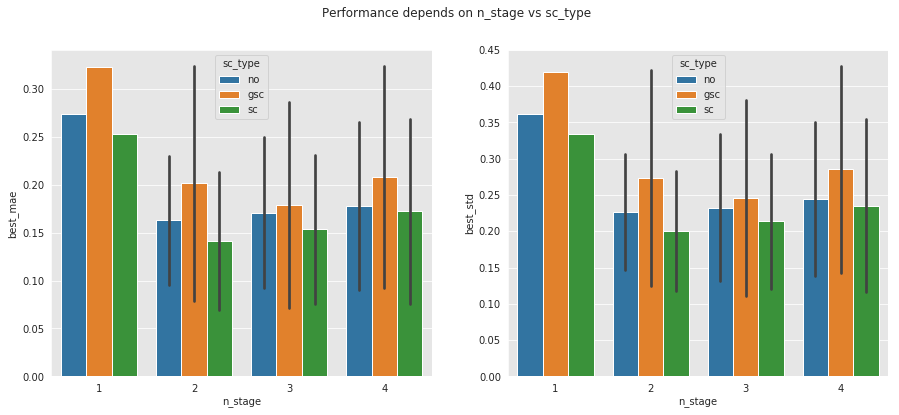

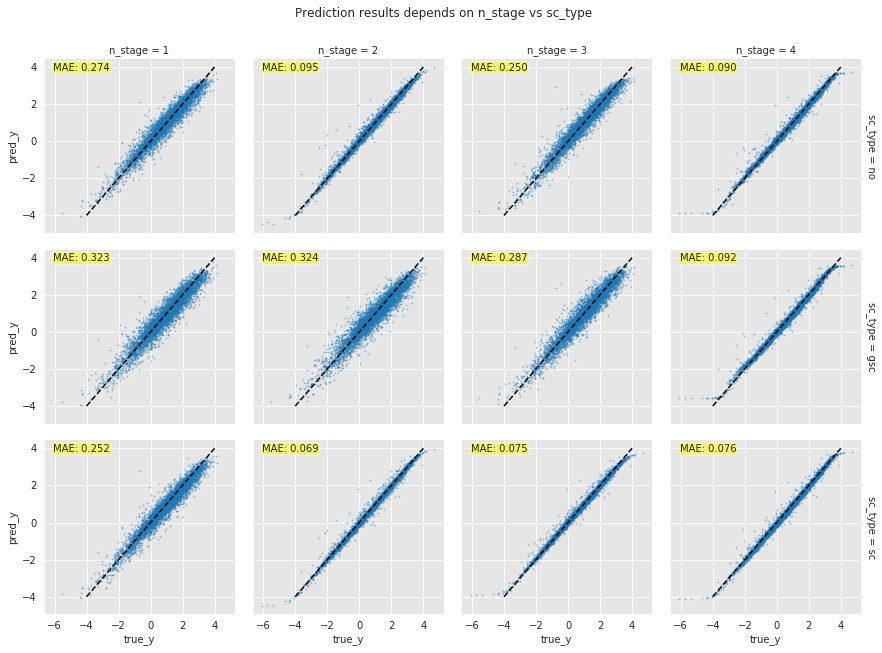

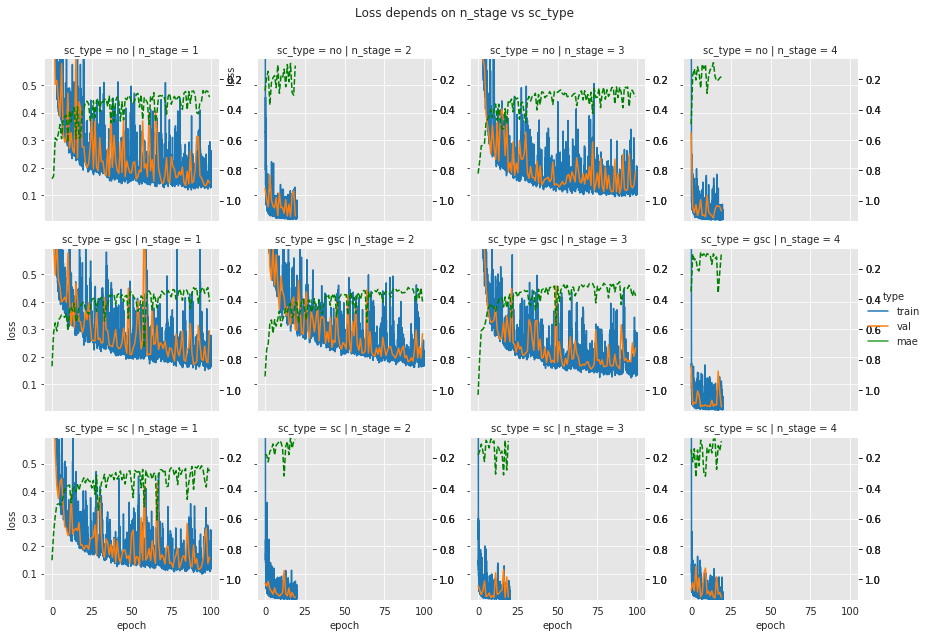

In [27]:
results = writer.read(exp_name='exp2_skipconnection_n_stage')

variable1 = 'n_stage'
variable2 = 'sc_type'


plot_performance(results, variable1, variable2,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp2_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 'best_mae',
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp2_Prediction {} vs {}'.format(variable1, variable2), top=0.9)

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp2_Loss {} vs {}'.format(variable1, variable2), top=0.9)

plt.show()


# Experiment.2 Block Type vs Batch Normalization

In this experiment, regression performance was measured by 'mae' metric among the variation of the type of the residual block(block_type) and the usage of the batch normalization layer in each residual block(use_bn).     

**Variable Domain**  
- block_type = ['a':'original, 'b':BN after addition, 'c':ReLU before addition, 'd':ReLU-only pre-activation]  
- use_bn = [True, False]

# Results and Discussion

1. The first figure shows the mae and std variation depends on the residual block type and the usage of the batch normalization layer. Also, it notify the experiment settings.  
2. The second figure shows the distribution between ground truth y and predicted y with y=x line(dashed).  
3. The last figure shows the train loss, validation loss(left y-axis) and mae score (right y-axis).  

**Notable Results**  
- Among 4 types of residual block, block A and C types are outperformed.
- When the batch normalization layer is used, the mae was almost reduced as half. 
- Also, when the batch normalization is applied, the mae values recorded less variation among different block types.

**Discussion**  
- The batch normalization layer boosts up the performance more than I expected. (very powerful).  
- Different residual block has less significant impact on the results.  

# Experiment.3 Trainable Embedding vs Start Channel

In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

exp_name = 'exp3_use_bn_emb_train'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 1
args.n_stage = 2
args.hidden_dim1 = 64
args.hidden_dim2 = 256
args.sc_type = 'sc'
args.use_atn = False
args.lr = 0.003
args.l2_coef = 0.001
args.optim = 'ADAM'
args.epoch = 100
args.batch_size= 2048
args.test_batch_size= 2048
args.emb_train = False
args.use_bn = True
args.dp_rate = 0.0
args.max_len = 50
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'n_stage', 'sc_type', 'use_bn', 'dp_rate', 'emb_train', 'epoch', 'l2_coef', 'lr'])


# Define Hyperparameter Search Space
variable1 = "use_bn"
variable2 = "emb_train"
list_var1 = [True, False]
list_var2 = [True, False]

# Initialize num iteration, num experiment, progress bar
n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_var1)*len(list_var2)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))

# writer.clear(exp_name)
for var1 in list_var1:
    for var2 in list_var2:
        ts = time.time()
        # Update hyperparameter
        args.use_bn = var1
        args.emb_train = var2
        args.bar = bar
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()

        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] {}: {}, {}: {}, got mae: {:2.3f}, std: {:2.3f} at epoch {:2} took {:3.1f}sec'.format(cnt_exp, variable1, var1, variable2, var2, result.best_mae, result.best_std, result.epoch, te-ts))

In [ ]:
results = writer.read(exp_name='exp3_use_bn_emb_train')
variable1 = "use_bn"
variable2 = "emb_train"


plot_performance(results, variable1, variable2, args,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp3_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 'best_mae',
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp3_Prediction {} vs {}'.format(variable1, variable2), top=0.9)

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp3_Loss {} vs {}'.format(variable1, variable2), top=0.9)

plt.show()


# Experiment.3 Trainable Embedding vs Start Channel

In this experiment, regression performance was measured by 'mae' metric among the number of the starting convolution filters(start_channel) and the usage of trainable atom embedding(emb_train).  

**Variable Domain**  
- emb_train = [True, False]
- start_channel = [4,8,16,32,64]

# Results and Discussion

1. The first figure shows the mae and std variation depends on the number of convolution channel of the first residual block(start_channel) and the trainability of the atom embedding vector(emb_train). Also, it notify the experiment settings.  
2. The second figure shows the distribution between ground truth y and predicted y with y=x line(dashed).  
3. The last figure shows the train loss, validation loss(left y-axis) and mae score (right y-axis).  

**Notable Results**  
- As the number of the start channel increased, the performance drastically improved. 
- When the embedding vectors were trained, the performance was slightly increased. 

**Discussion**  
- Increasing the number of the convolution filter results in the increasing performance. However lots of computation power required.     
- Training original embedding vector is meaningful to increase the performance. 

In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

exp_name = 'exp4_dp_rate'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 1
args.n_stage = 2
args.hidden_dim1 = 64
args.hidden_dim2 = 256
args.sc_type = 'sc'
args.use_atn = False
args.lr = 0.003
args.l2_coef = 0.001
args.optim = 'ADAM'
args.epoch = 300
args.batch_size= 256
args.test_batch_size= 256
args.emb_train = True
args.use_bn = True
args.dp_rate = 0.0
args.max_len = 50
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'n_stage', 'sc_type', 'use_bn', 'dp_rate', 'emb_train', 'epoch', 'l2_coef', 'lr'])


# Define Hyperparameter Search Space
variable1 = "dp_rate"
list_var1 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# Initialize num iteration, num experiment, progress bar
n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_var1)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))

# writer.clear(exp_name)
for var1 in list_var1:
    ts = time.time()
    # Update hyperparameter
    args.dp_rate = var1
    args.bar = bar
    result = experiment(partition, args)
    writer.write(result)
    torch.cuda.empty_cache()
    te = time.time()

    cnt_exp += 1
    bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
    print('[Exp {:2}] {}: {}, got mae: {:2.3f}, std: {:2.3f} at epoch {:2} took {:3.1f}sec'.format(cnt_exp, variable1, var1, result.best_mae, result.best_std, result.epoch, te-ts))

In [ ]:
results = writer.read(exp_name='exp4_dp_rate')
variable1 = "dp_rate"
variable2 = "emb_train"


plot_performance(results, variable1, variable2, args,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp4_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 'best_mae',
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp4_Prediction {} vs {}'.format(variable1, variable2), top=0.8)

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp4_Loss {} vs {}'.format(variable1, variable2), top=0.8)

plt.show()


# Experiment.5 Attention Mechanism vs Connection

In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

exp_name = 'exp5_use_attn_n_layer'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 3
args.n_stage = 1
args.hidden_dim1 = 64
args.hidden_dim2 = 256
args.n_attn_head = 4
args.sc_type = 'sc'
args.use_attn = False #True
args.lr = 0.001
args.l2_coef = 0.001
args.optim = 'ADAM'
args.epoch = 60
args.batch_size= 512
args.test_batch_size= 512
args.emb_train = True
args.use_bn = True
args.dp_rate = 0.0
args.max_len = 50
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'n_stage', 'sc_type', 'use_bn', 'use_attn', 'dp_rate', 'emb_train', 'epoch', 'l2_coef', 'lr'])


# Define Hyperparameter Search Space
list_var1 = [True, False] #, False]#, 2, 3, 4]#, 4, 8]#[0.01, 0.001, 0.0001, 0.00001]
list_var2 = [1, 2, 3, 4, 5, 6, 7, 8]#,2,3] #[10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]

# Initialize num iteration, num experiment, progress bar
n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_var1)*len(list_var2)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))

writer.clear(exp_name)
for var2 in list_var2:
    for var1 in list_var1:
        ts = time.time()
        # Update hyperparameter
        args.use_attn = var1
        args.n_layer = var2
        
        args.bar = bar
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()

        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} took {:3.1f}sec'.format(cnt_exp, result.best_mae, result.best_std, result.epoch, te-ts))

124801
[Exp  1] got mae: 0.080, std: 0.130 at epoch 60 took 228.9sec
124801
[Exp  2] got mae: 0.073, std: 0.119 at epoch 60 took 225.3sec
130241
[Exp  3] got mae: 0.059, std: 0.097 at epoch 60 took 343.5sec
129217
[Exp  4] got mae: 0.060, std: 0.096 at epoch 60 took 305.2sec
135681
[Exp  5] got mae: 0.055, std: 0.092 at epoch 60 took 474.8sec
133633


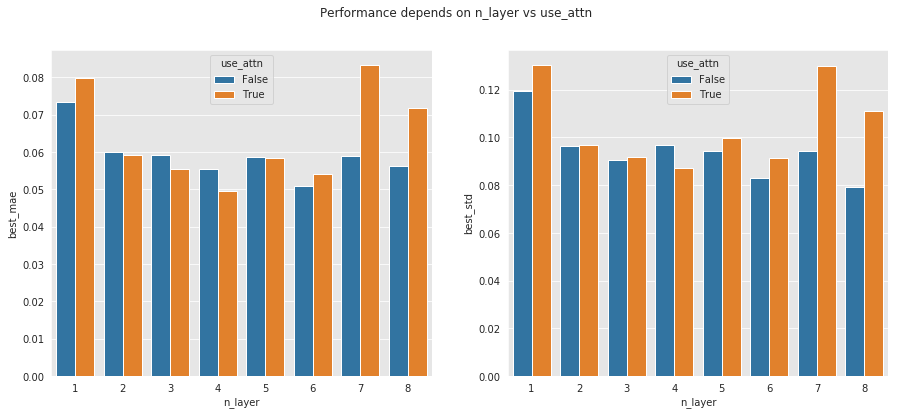

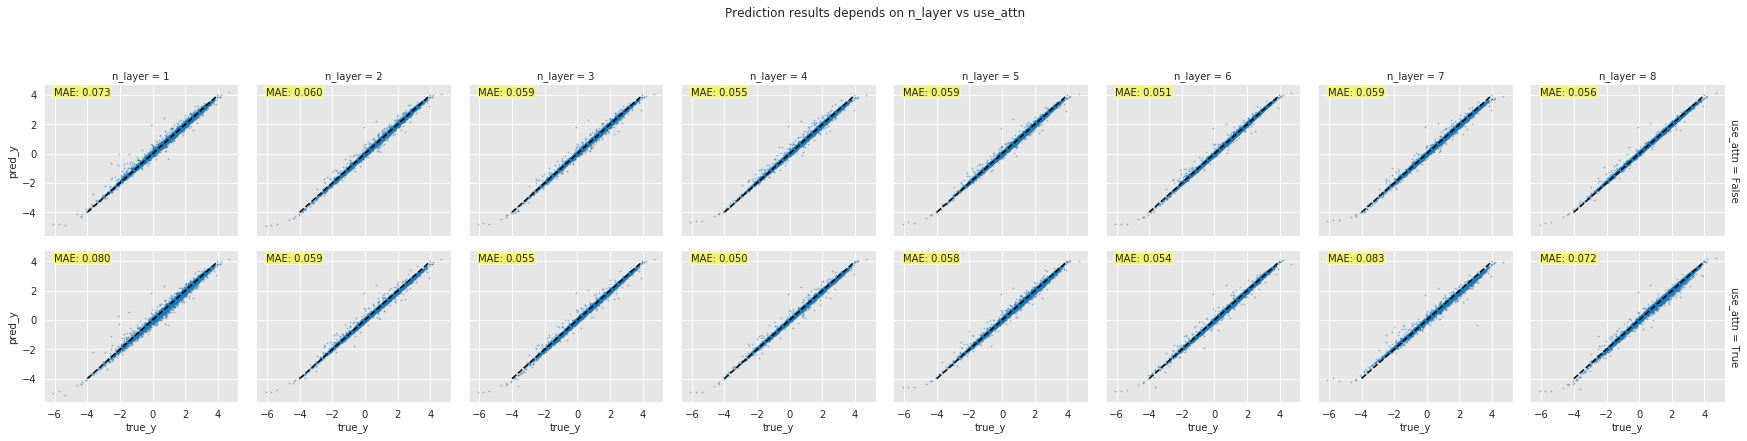

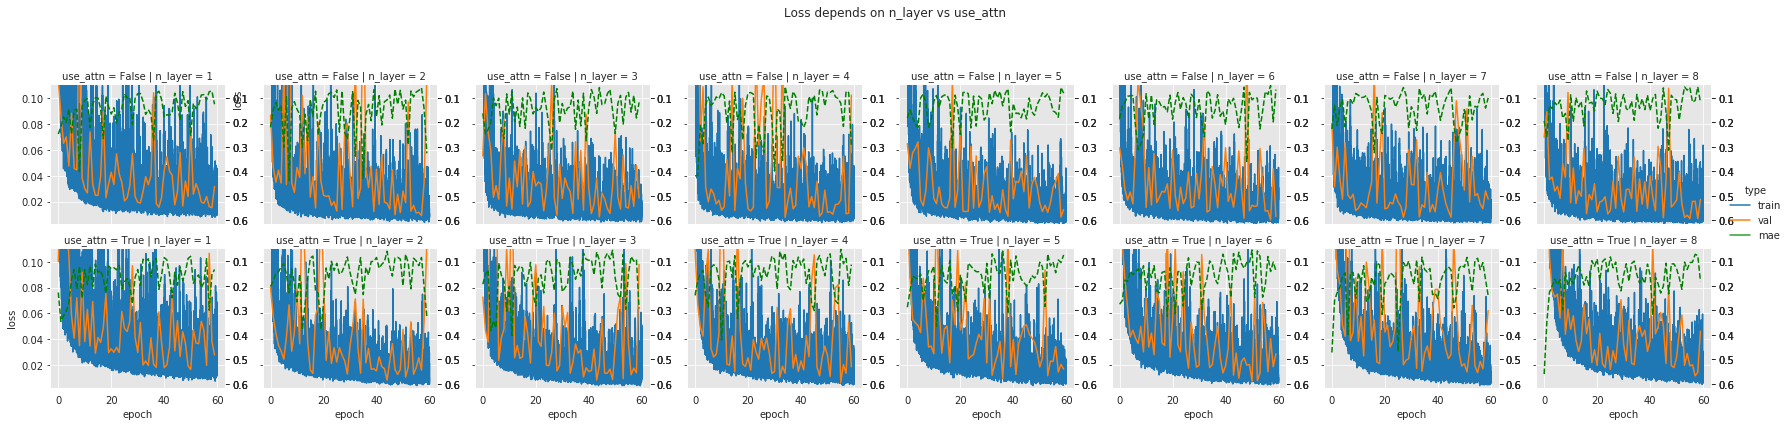

In [11]:
results = writer.read(exp_name='exp5_use_attn_n_layer')
variable1 = "n_layer"
variable2 = "use_attn"


plot_performance(results, variable1, variable2,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp5_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 'best_mae',
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp5_Prediction {} vs {}'.format(variable1, variable2), top=0.8)


plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp5_Loss {} vs {}'.format(variable1, variable2), top=0.8)

plt.show()
